In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import r2_score
   


In [2]:
def model_building(X_train, y_train, X_test, y_test, look_back,scaler): 
                
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                
    model = Sequential()
    model.add(LSTM(4,input_shape=(1,look_back)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_train, y_train, epochs=5, verbose=0)
    
    
    #------ Prediction ------ #
    
    train_predict = model.predict(X_train)
    train_predict = scaler.inverse_transform(train_predict)
    
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.2f RMSE' % (test_score))
    
    # R2
    print("R2 score on train data:",r2_score(y_train,train_predict))
    print("R2 score on test data:",r2_score(y_test,test_predict))

    joined_data = np.concatenate((train_predict,test_predict),axis=0)
    return train_predict, test_predict,joined_data,model
  

In [3]:
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
output_notebook()

def plotting(trainPredictPlot, testPredictPlot):

    # initialize testPredictPlot with NaN values
    testPredictPlot_empty = np.empty_like(trainPredictPlot)
    testPredictPlot_empty[:] = np.nan
    
    # now concatenate trainPredictPlot with testPredictPlot
    testPredictPlot = np.concatenate((testPredictPlot_empty, testPredictPlot), axis=0)

    
    plt.plot(trainPredictPlot, label='Train data')
    
    plt.plot(testPredictPlot, label='Predicted data')
    #plt.plot(joined, label='Joined data',color='black')
    plt.legend()

    plt.show()
    

Loading BokehJS ...

In [4]:
def stacked_lstm(financial_data,record_to_plot:int=2000):
    financial_data = financial_data.reset_index()
    financial_data = financial_data[:record_to_plot]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(financial_data['Close']).reshape(-1, 1))
    
    # Splitting dataset into train and test split
    # As we are using time series data, we need to split the data in train and test on the basis of time not just take the first 80% data as train and remaining as test
    
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=6)
    print(tscv)
    results = {}
    for train_index, test_index in tscv.split(scaled_data):
    
        train = scaled_data[train_index]
        test = scaled_data[test_index]
     
        def create_dataset(dataset, look_back:int=0):
            X, Y = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back)]
                X.append(a)
                Y.append(dataset[i + look_back])
            return np.array(X), np.array(Y)
        
        
        lookback = 1
        X_train, y_train = create_dataset(train, lookback)
        X_test, y_test = create_dataset(test, lookback)
        

        
        trainPredictPlot, testPredictPlot,joined,model = model_building(X_train,y_train,X_test,y_test,lookback,scaler)

        true_data = financial_data['Close']
        plotting(trainPredictPlot, testPredictPlot)
    
    
    return true_data,joined,model
            

In [5]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [6]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None)
9/9 [==============================] - 0s 2ms/step
Train Score: 0.06 RMSE
Test Score: 0.03 RMSE
R2 score on train data: -10.56232608469084
R2 score on test data: -0.7628402186101999


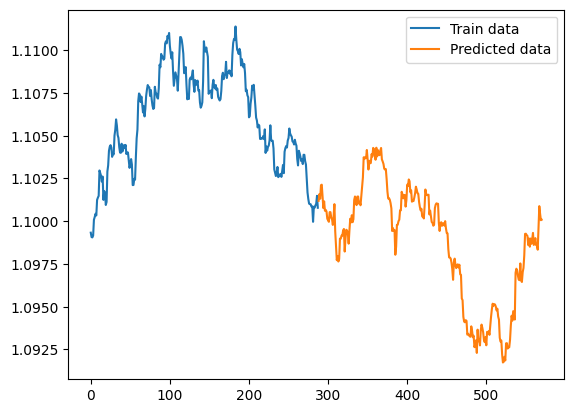

9/9 [==============================] - 0s 2ms/step
Train Score: 0.03 RMSE
Test Score: 0.04 RMSE
R2 score on train data: -0.27314988109787564
R2 score on test data: -4.905312976181387


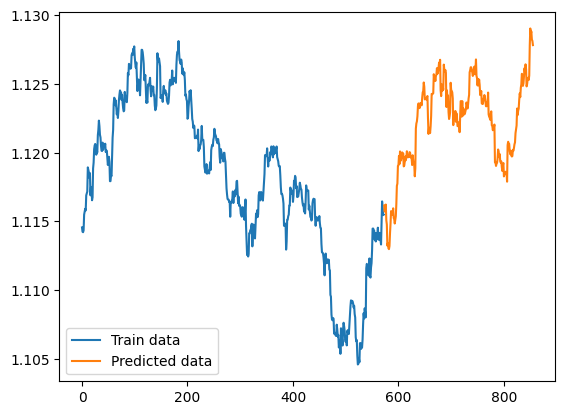

9/9 [==============================] - 0s 2ms/step
Train Score: 0.04 RMSE
Test Score: 0.13 RMSE
R2 score on train data: -1.5594585301778867
R2 score on test data: -19.526782111365094


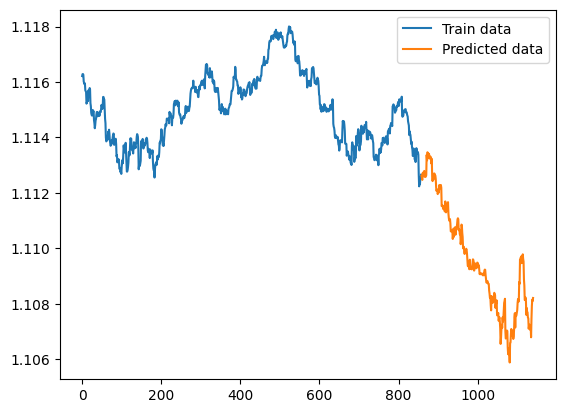

9/9 [==============================] - 0s 2ms/step
Train Score: 0.03 RMSE
Test Score: 0.05 RMSE
R2 score on train data: 0.6386067627882102
R2 score on test data: -5.039609378009618


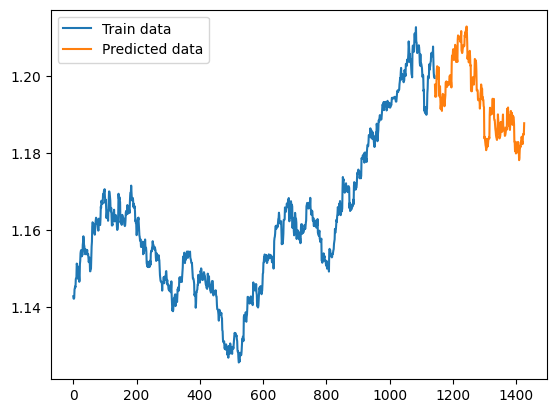

9/9 [==============================] - 0s 2ms/step
Train Score: 0.03 RMSE
Test Score: 0.01 RMSE
R2 score on train data: 0.7055549223053863
R2 score on test data: -0.002372153946499589


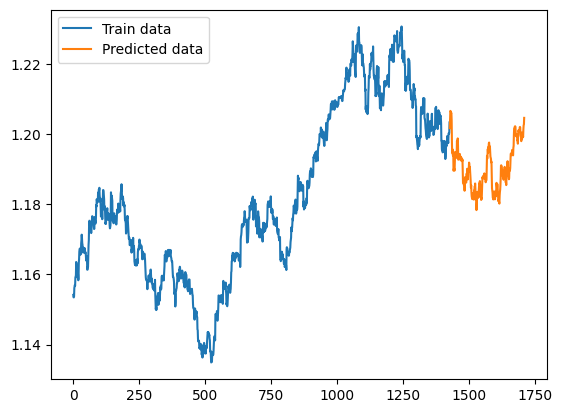

9/9 [==============================] - 0s 2ms/step
Train Score: 0.05 RMSE
Test Score: 0.05 RMSE
R2 score on train data: 0.09279940769190964
R2 score on test data: -11.411323757643382


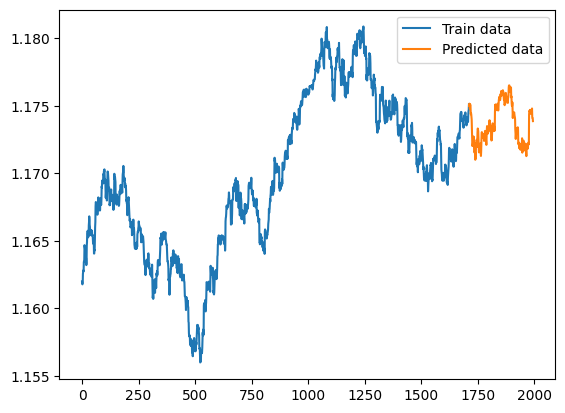

In [7]:
true_data,joined,model = stacked_lstm(financial_data,record_to_plot=2000)



(2000,)
(1996, 1)


1/1 [==============================] - 0s 22ms/step
[1.22196    0.50881916 0.43563992 0.42687911 0.42581469 0.42568511
 0.42566937 0.42566741 0.42566717 0.42566717 0.42566717 0.42566717
 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717
 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717
 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717 0.42566717
 0.42566717]


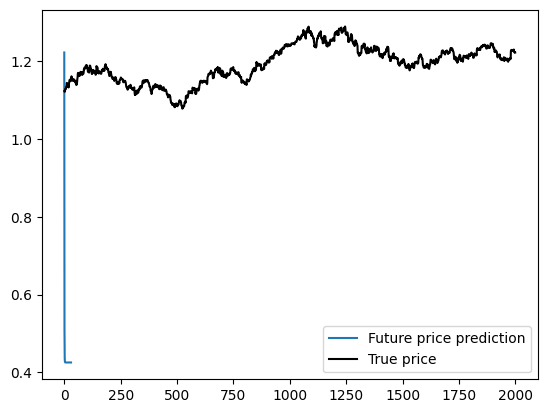

In [8]:
print(true_data.shape)
print(joined.shape)

# predict the future price for 30 days using the model we trained
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(np.array(financial_data['Close']).reshape(-1, 1))
scaler.transform(np.array(financial_data['Close']).reshape(-1, 1))
def predict_future_price(model, true_data, look_back:int=1, future_days:int=30):
    prediction_list = true_data[-look_back:]
    
    for _ in range(future_days):
        x = prediction_list[-look_back:]
        # x 'Series' object has no attribute 'append'
        x = np.reshape(x, (len(x), 1, 1))
      
        x = x.reshape((1, 1, look_back))

          
        out = model.predict(x)[0][0]
        
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    
    return prediction_list
    
future_price = predict_future_price(model, true_data, look_back=1, future_days=30)
print(future_price)

plt.plot(future_price, label='Future price prediction')
plt.plot(true_data, label='True price',color='black')
plt.legend()
plt.show()
